# Project 4: Unsupervised Learning – NLP

## Project Objective
Using scraped data from TED.com, use NLP techniques to identify topics for talks that are tagged `sex`, `religion`, and `politics`.

### Project Motivation
`sex`, `religion`, and `politics` are topics that society has deemed improper or unacceptable to discuss openly. 

Let's see what TED speakers have to say about them...


### Future Work
* Predict tags for any given talk(s)
* Recommendation system
    * Related talks
    * Create playlist
* Summarizer
* Talk Generator

## Libraries

In [234]:
# Web scraping
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent
import time
import random

# Data storage
import pickle
import pandas as pd

# Text processing
import re
import string
from collections import Counter
import scipy.sparse

# NLP Models
import spacy
# import stanfordnlp
# from spacy_stanfordnlp import StanfordNLPLanguage

# Sklearn
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF
from sklearn.feature_extraction import text 

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim import matutils, models

# Visualization
from pprint import pprint
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# import pyLDAvis.gensim
# import pyLDAvis.gensim as gensimvis
# from spacy import displacy
# from tabulate import tabulate

# Getting the data
##### Features to be scraped
* Speaker (author)
* Title
* Transcript
* Related tags
* About the talk

##### Nice to have for future work
* Date
* About the speaker
* Views
* Talk length

In [ ]:
def make_soup(url):
    """Make soup for each Ted Talk transcript url."""
    # Generate random user-agent
    user_agent = {'User-agent': UserAgent().random}
    
    # Request page and make soup
    page = requests.get(url, headers=user_agent)
    soup = BeautifulSoup(page.content, 'lxml')
    return soup

In [ ]:
def get_max_page():
    """Return the max pagination number from Ted's home page."""
    page_num = []
    
    # Set language to English and sort by newest talks
    soup = make_soup('https://www.ted.com/talks?language=en&page=1&sort=newest')
    
    # Iterate through each pagination element and get the max
    for element in soup.find_all('a', class_='pagination__item pagination__link'):
        page_num.append(int(element.text))
    return max(page_num)

In [ ]:
def get_talk_urls():
    """Return all the talk urls in each talks page.
    Filter for talks in English.
    """
    talk_url_list = []
    
    # Set language to English
    talks_url = 'https://www.ted.com/talks?language=en&page='
    
    # Set range from 1 to the max page in the pagination element
    page_range = range(1, get_max_page()+1)
    
    # Iterate through each page and get the url for each talk
    for i in page_range:
        
        # Try a second attempt if first attempt fails
        for attempt in range(2):
            try:
                talks_page_url = talks_url + str(i) + '&sort=newest'
                soup = make_soup(talks_page_url)

                # Delay between searches
                time.sleep(random.uniform(1, 2))

                for div in soup.find_all('div', attrs={'class': 'media__image'}):
                    for a in div.find_all('a'):
                        talk_url_list.append(a.get('href'))
            except:
                # Delay before continuing to second attempt
                time.sleep(random.uniform(2, 3))
            
            # Break if no exceptions are raised
            else:
                break
            
    return talk_url_lis

In [ ]:
def construct_url():
    """Construct complete url for each talk's transcript page.
    Remove '?language=en' from the end of the url.
    """
    return ['https://www.ted.com' + url.replace('?language=en', '') + '/transcript' for url in get_talk_urls()]

In [ ]:
def get_data():
    """Return nested dictionary with title, speaker, related tags, and transcript from each talk's transcript page."""
    # Create empty dict to nest dicts (1 nested dict per talk)
    ted_dict = {}
    
    # 1. Used to create nested dicts in 'ted_dict'
    # 2. Used as count for successfully scraped pages
    dict_id = 0
    
    # Counter for failed scraped pages
    failed_counter = 0
    
    # Iterate through each ted talk transcript url
    for url in construct_url():
        # Make soup
        soup = make_soup(url)

        # Delay between searches
        time.sleep(random.uniform(.5, 2))
        
        # Try up to three attempts to scrape data
        for attempt in range(1, 3+1):
            try:    
                # Get title
                title_tag = soup.find(attrs={'name': 'title'})

                # Get speaker
                speaker_tag = soup.find(attrs={'name': 'author'})

                # Get related tags
                match_obj = re.search(r"\"tag\":\"(.*?)\"", soup.text)
                match_obj.group(1)
                ted_tags = match_obj.group(1).split(',')

                # Get talk description
                desc_tag = soup.find(attrs={'property': 'og:description'})
                desc_str = desc_tag.attrs['content'].split(': ', 1)[1] # Split description at "TED Talk Subtitles and Transcript:"

                # Get transcript
                transcript = ''
                transcript_strings = []
                for div in soup.find_all('div', class_="Grid__cell flx-s:1 p-r:4"):
                    for p in div.find_all('p'):
                        # Add every string in the transcript to a list
                        transcript_strings.append(" ".join(p.text.split()))
                    else:
                        # After all strings have been added, create a single transcript string
                        transcript = " ".join(transcript_strings)

                # Add 1 to create a new dict_id and use it to create a nested dict
                dict_id += 1
                ted_dict[dict_id] = {}

                # Add the features above to the nested dict
                ted_dict[dict_id]['title'] = title_tag.attrs['content'].split(':')[1].strip()
                ted_dict[dict_id]['speaker'] = speaker_tag.attrs['content']
                ted_dict[dict_id]['tags'] = ted_tags
                ted_dict[dict_id]['description'] = desc_str
                ted_dict[dict_id]['transcript'] = transcript
                
                # Indicate successfull scrape
                print(dict_id, url)

            except Exception as e:
                # If the last attempt fails, update the failed counter and print the exception & talk url for debugging
                if attempt == 3:
                    failed_counter += 1
                    print(f'position: {dict_id}, exception: {e}, url: {url}\n')
                    continue
                
                # Delay before another attempt
                time.sleep(random.uniform(4, 6))
            
            # Break if no exceptions are raised
            else:
                break

    print(f"""Ted.com scraping results:
        \n\t• Success: {dict_id}
        \n\t• Failed: {failed_counter}\n""")
    
    return ted_dict

In [ ]:
# Call web scraping function
# ted_dict = get_data()
# print(ted_dict)

## Create dataframe

In [ ]:
# Save pickle
# with open('data/ted_dict_complete.pkl', 'wb') as f:
#     pickle.dump(ted_dict, f)

In [ ]:
# Create dataframe
df = pd.DataFrame.from_dict(ted_dict, orient='index')

# Pickle dataframe
df.to_pickle('data/first_df.pkl')

print(f'Shape: {df.shape}')

We were able to successfully scrape 3904 talks (as of February 21, 2020)!  

Only one talk failed as the transcript doesn't load, maybe we should notify TED about this bug...  
https://www.ted.com/talks/marcus_bullock_an_app_that_helps_incarcerated_people_stay_connected_to_their_families/transcript


# Data Cleaning

* Load scraped data and create a dataframe
* Reduce scope
* Clean data
* Lemmatization (spaCy)
* Save stop words (spaCy)
* Create corpora
    * One that includes all tags
    * One for each tag
        * sex, religion, politics
    * One for different parts-of-speech or entities:
        * all text, nouns & adjectives, named entities, verbs
* Create document-term matrices

## Reduce Scope
Filter for talks about `sex`, `religion`, and `politics`

In [46]:
def check_tag(tag):
    """Input tag and return a list of booleans for talks that contain 'tag' by index"""
    contains_tag = []
    for ix, tag_list in enumerate(df['tags']):
        if any(tag in t for t in tag_list):
            contains_tag.append(1)
        else:
            contains_tag.append(0)
    return contains_tag

In [47]:
# Add series for selected tags
df['is_sex'] = check_tag('sex')
df['is_religion'] = check_tag('religion')
df['is_politics'] = check_tag('politics')

In [48]:
# Filter dataframe to only include talks about sex, religion, and politics
df = df.loc[(df['is_sex']==1) | (df['is_religion']==1) | (df['is_politics']==1), : ].reset_index(drop=True)

# Create new dataframes for each tag (for later use)
sex_df = df.loc[(df['is_sex']==1), : ].reset_index(drop=True)
religion_df = df.loc[(df['is_religion']==1), : ].reset_index(drop=True)
politics_df = df.loc[(df['is_politics']==1), : ].reset_index(drop=True)

### All talks dataframe
Consruct a 3x1 dataframe with all talks for each tag for analyzing most common words.

In [49]:
def combine_transcripts(list_of_text):
    """Input a list of text and return them into one large chunk of text."""
    combined_text = ' '.join(list_of_text)
    return combined_text

In [50]:
def transcripts_to_dict(dataframe, tag_list):
    """Create a dictionary of transcripts for each tag.
    Input a dataframe and tag list.
    Return a nested dictionary.
    """
    ted_dict = {}
        
    # Assign parameter to tags
    tags = tag_list
    for tag in tag_list:
        # Filter dataframe to specific series and convert it to a list
        filter_string = 'is_' + str(tag)
        text_list = dataframe.loc[(df[filter_string]==1), 'transcript'].to_list()

        # Call combine_transcripts function to return combined text
        combined_text = combine_transcripts(text_list)

        # Add combined text to dict
        ted_dict[tag] = combined_text
    return ted_dict

In [51]:
# Create dictionary from the dataframe
transcript_dict = transcripts_to_dict(df, ['sex', 'religion', 'politics'])

# Construct dataframe from dictionary 
df = pd.DataFrame.from_dict(transcript_dict, orient='index')
df.rename({0: 'transcript'}, axis=1, inplace=True)

## Clean text

In [52]:
def clean_text(text):
    """
    Remove:
        *text in square brackets & parenthesis
        *punctuation
        *words containing numbers
        *double-quotes, dashes
    """
#     text = text.lower()
    text = re.sub('[\[\(].*?[\)\]]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[\“\–]', '', text)
    return text

In [53]:
# Clean text
df['transcript'] = pd.DataFrame(df['transcript'].apply(lambda x: clean_text(x)))
sex_df['transcript'] = pd.DataFrame(sex_df['transcript'].apply(lambda x: clean_text(x)))
religion_df['transcript'] = pd.DataFrame(religion_df['transcript'].apply(lambda x: clean_text(x)))
politics_df['transcript'] = pd.DataFrame(politics_df['transcript'].apply(lambda x: clean_text(x)))

In [54]:
# Pickle dataframe
df.to_pickle('data/sex_religion_politics_corpus.pkl')
sex_df.to_pickle('data/sex_corpus.pkl')
religion_df.to_pickle('data/religion_corpus.pkl')
politics_df.to_pickle('data/politics_corpus.pkl')

## Corpora

In [57]:
# # Stanford NLP model
# snlp = stanfordnlp.Pipeline(lang="en")
# nlp = StanfordNLPLanguage(snlp)

# Load SpaCy English model
nlp = spacy.load('en_core_web_sm') # other models available 'md, 'lg'

# Transform dataframes to list of docs (corpus)
all_srp_texts = df.loc[:, 'transcript'].to_list()
sex_texts = sex_df.loc[:, 'transcript'].to_list()
religion_texts = religion_df.loc[:, 'transcript'].to_list()
politics_texts = politics_df.loc[:, 'transcript'].to_list()

# Process the corpus
all_srp_docs = list(nlp.pipe(all_srp_texts)) # disable=['tagger', 'parser', 'textcat']
sex_docs = list(nlp.pipe(sex_texts))
religion_docs = list(nlp.pipe(religion_texts))
politics_docs = list(nlp.pipe(politics_texts))

In [72]:
# # Pickle docs
# with open('data/all_srp_docs.pkl', 'wb') as f:
#     pickle.dump(all_srp_docs, f)
#     f.close()
    
# with open('data/sex_docs.pkl', 'wb') as f:
#     pickle.dump(sex_docs, f)
#     f.close
    
# with open('data/religion_docs.pkl', 'wb') as f:
#     pickle.dump(religion_docs, f)
#     f.close()
    
# with open('data/politics_docs.pkl', 'wb') as f:
#     pickle.dump(politics_docs, f)
#     f.close()

# # Load pickled spaCy 'docs' object
# with open('data/_____.pkl', 'rb') as f:
#     _____ = pickle.load(f)
#     f.close()

### Corpus: All text

In [61]:
def get_all_text(spaCy_doc, tag_list):
    """
    Input a spaCy Doc object (corpus) and tag list.
    Return a dictionary of lemmatized text.
    Keep alphanumeric characters and non stop words.
    """
    tags = tag_list
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        tag = tags[ix]
        token_list = []
        for token in doc:
            if (token.is_alpha==1) & (token.is_stop==0):
                token_list.append((token.lemma_).lower())
        my_dict[tag] = ' '.join(token_list)
    return my_dict

In [65]:
# Create dictionary with all text
all_srp_text_dict = get_all_text(all_srp_docs, ['sex', 'religion', 'politics'])

In [66]:
# Construct dataframe
all_srp_text_df = pd.DataFrame.from_dict(all_srp_text_dict, orient='index')
all_srp_text_df.rename({0: 'transcript'}, axis=1, inplace=True)
all_srp_text_df.head()

,transcript
sex,teen terrible period crippling cramp leak bloo...
religion,lord shiva primordial destroyer evil slayer de...
politics,team researcher hold math test exam administer...


In [112]:
# Pickle dataframe
all_srp_text_df.to_pickle('data/all_srp_text_df.pkl')

### Corpus: *Nouns & adjectives*
Applies to all tags together & individually: `sex`, `religion`, and `politics`

In [68]:
def get_nouns_adj(spaCy_doc, tag_list):
    """
    Input a spaCy Doc object (corpus) and tag list.
    Return a dictionary of lemmatized nouns and adjectives per doc.
    Keep alphanumeric characters and non stop words.
    """
    tags = tag_list
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        tag = tags[ix]
        token_list = []
        for token in doc:
            if (token.is_alpha==1) & (token.is_stop==0) & (token.pos_ in ['NOUN', 'ADJ']):
                token_list.append((token.lemma_).lower())
        my_dict[tag] = ' '.join(token_list)
    return my_dict

In [88]:
# Get list of titles
sex_title_list = [title for title in sex_df['title']]
religion_title_list = [title for title in religion_df['title']]
politics_title_list = [title for title in politics_df['title']]

# Create nouns and adjective dictionaries
all_srp_nouns_adj_dict = get_nouns_adj(all_srp_docs, ['sex', 'religion', 'politics'])
sex_nouns_adj_dict = get_nouns_adj(sex_docs, sex_title_list)
religion_nouns_adj_dict = get_nouns_adj(religion_docs, religion_title_list)
politics_nouns_adj_dict = get_nouns_adj(politics_docs, politics_title_list)

In [89]:
# Construct dataframe – all tags
all_srp_nouns_adj_df = pd.DataFrame.from_dict(all_srp_nouns_adj_dict, orient='index')
all_srp_nouns_adj_df.rename({0: 'transcript'}, axis=1, inplace=True)

# Construct dataframe – sex
sex_nouns_adj_df = pd.DataFrame.from_dict(sex_nouns_adj_dict, orient='index')
sex_nouns_adj_df.rename({0: 'transcript'}, axis=1, inplace=True)

# Contruct dataframe – religion
religion_nouns_adj_df = pd.DataFrame.from_dict(religion_nouns_adj_dict, orient='index')
religion_nouns_adj_df.rename({0: 'transcript'}, axis=1, inplace=True)

# Construct dataframe – politics
politics_nouns_adj_df = pd.DataFrame.from_dict(politics_nouns_adj_dict, orient='index')
politics_nouns_adj_df.rename({0: 'transcript'}, axis=1, inplace=True)

In [90]:
# Pickle dataframes
all_srp_nouns_adj_df.to_pickle('data/all_srp_nouns_adj_df.pkl')
sex_nouns_adj_df.to_pickle('data/sex_nouns_adj_df.pkl')
religion_nouns_adj_df.to_pickle('data/religion_nouns_adj_df.pkl')
politics_nouns_adj_df.to_pickle('data/politics_nouns_adj_df.pkl')

### Corpus: Named Entities

In [71]:
def get_named_entities(spaCy_doc, tag_list):
    """
    Input a spaCy Doc object (corpus) and tag list.
    Return a dictionary of named entities per doc.
    """
    tags = tag_list
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        tag = tags[ix]
        entity_list = []
        for ent in doc.ents:
            # People including fictional
            # Nationalities or religious or political groups
            if (ent.label_=='PERSON') or (ent.label_=='NORP'):
                entity_list.append(ent.text)
        my_dict[tag] = ' '.join(entity_list)
    return my_dict

In [73]:
# Create dictionary with named entities
all_srp_named_entities_dict = get_named_entities(all_srp_docs, ['sex', 'religion', 'politics'])

In [74]:
# Construct dataframe
all_srp_named_entities_df = pd.DataFrame.from_dict(all_srp_named_entities_dict, orient='index')
all_srp_named_entities_df.rename({0: 'transcript'}, axis=1, inplace=True)
all_srp_named_entities_df.head()

,transcript
sex,Freud Tony Porter longterm Moroccan Muslim Rap...
religion,Shiva Shiva Parvati Parvati Shiva Shiva Brahma...
politics,American Imagine Thomas Sankara West African K...


In [75]:
# Pickle dataframe
all_srp_named_entities_df.to_pickle('data/all_srp_named_entities_df.pkl')

### Corpus: Verbs

In [76]:
def get_verbs(spaCy_doc, tag_list):
    """
    Input a spaCy Doc object (corpus) and tag list.
    Return a dictionary of lemmatized text.
    Keep alphanumeric characters and non stop words.
    """
    tags = tag_list
    my_dict = {}
    for ix, doc in enumerate(spaCy_doc):
        tag = tags[ix]
        token_list = []
        for token in doc:
            if token.pos_=='VERB':
                token_list.append((token.lemma_).lower())
        my_dict[tag] = ' '.join(token_list)
    return my_dict

In [79]:
# Create dictionary with all text
all_srp_verbs_dict = get_verbs(all_srp_docs, ['sex', 'religion', 'politics'])

In [81]:
# Construct dataframe
all_srp_verbs_df = pd.DataFrame.from_dict(all_srp_verbs_dict, orient='index')
all_srp_verbs_df.rename({0: 'transcript'}, axis=1, inplace=True)
all_srp_verbs_df.head()

,transcript
sex,leak miss remember sit think s eat leak go lea...
religion,test maintain depend would become would remain...
politics,hold administer design test evaluate hide use ...


In [82]:
# Pickle dataframe
all_srp_verbs_df.to_pickle('data/all_srp_verbs_df.pkl')

## Document-Term Matrices

### Stop words

In [91]:
def get_stop_words(spaCy_doc_obj):
    """Input a spaCy Doc and return a list of stop words"""
    stop_words = []
    for doc in spaCy_doc_obj:
        for token in doc:
            if token.is_stop:
                stop_words.append(token.text.lower())
    return set(stop_words)

In [105]:
# Initial stop word list
stop_words_spacy = list(get_stop_words(all_srp_docs))

# Pickle for later use
with open('data/stop_words_spacy.pkl', 'wb') as f:
    pickle.dump(stop_words_spacy, f)
    f.close()

In [96]:
def create_document_term_matrix(dataframe):
    """Input a dataframe and return a document-term matrix with initial stop words"""
    cv = CountVectorizer(stop_words=stop_words_spacy)
    data_cv = cv.fit_transform(dataframe['transcript'])
    dtm_df = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
    dtm_df.index = dataframe.index
    return dtm_df

In [ ]:
# Create document-term matrices for corpora
all_srp__all_text_dtm = create_document_term_matrix(all_srp__text_df)
all_srp__nouns_adj_dtm = create_document_term_matrix(all_srp__nouns_adj_df)
all_srp__named_entities_dtm = create_document_term_matrix(all_srp__named_entities_df)
all_srp__verbs_dtm = create_document_term_matrix(all_srp__verbs_df)

In [98]:
# Pickle document-term matrices
all_srp__all_text_dtm.to_pickle('data/all_srp__all_text_dtm.pkl')
all_srp__nouns_adj_dtm.to_pickle('data/all_srp__nouns_adj_dtm.pkl')
all_srp__named_entities_dtm.to_pickle('data/all_srp__named_entities_dtm.pkl')
all_srp__verbs_dtm.to_pickle('data/all_srp__verbs_dtm.pkl')

# Word Clouds

## Word Cloud – All Text

### Update stop words

In [99]:
# Load document-term matrices
all_srp__all_text_dtm = pd.read_pickle('data/all_srp__all_text_dtm.pkl')

# Transpose document-term matrix
all_srp__all_text_dtm_transposed = all_srp__all_text_dtm.transpose()

In [100]:
# Find the top words said by each tag
n_words = 10
top_dict = {}
for tag in all_srp__all_text_dtm_transposed.columns:
    top = all_srp__all_text_dtm_transposed[tag].sort_values(ascending=False).head(n_words)
    top_dict[tag]= list(zip(top.index, top.values))
    
# Print the top words said by each tag
for tag, top_words in top_dict.items():
    print(tag)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
like, woman, sex, know, people, think, want, man, thing, time
---
religion
people, think, like, know, world, thing, god, come, way, life
---
politics
people, think, world, like, know, year, thing, country, want, come
---


In [101]:
# Look at the most common top words --> add them to the stop word list

# Let's first pull out the top words for each tag
words = []
for tag in all_srp__all_text_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[tag]]
    for t in top:
        words.append(t)

In [129]:
# Let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('people', 3), ('thing', 3), ('time', 3), ('way', 3), ('year', 3), ('world', 2), ('good', 2), ('woman', 1), ('sex', 1), ('man', 1), ('sexual', 1), ('girl', 1), ('life', 1), ('religion', 1), ('human', 1), ('country', 1), ('power', 1), ('political', 1)]


In [130]:
# If all three tags have the top word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
add_stop_words

['people', 'thing', 'time', 'way', 'year']

In [131]:
# Add custom stop words
custom_stop_words = [
#     'sex',
    'world',
#     'religion',
#     'god',
#     'religious',
#     'political',
#     'not',
    'know',
    'thing',
    'know',
    'think',
    'come',
#     'people'
]

In [132]:
# Load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [133]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [134]:
# Add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

In [116]:
# Let's update our document-term matrix with the new list of stop words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# Load data frame
all_srp__text_df = pd.read_pickle('data/all_srp__text_df.pkl')

# Count vectorize the dataframe
data_cv = cv.fit_transform(all_srp__text_df['transcript'])

# Construct new dataframe
all_srp__text_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp__text_dtm_stop.index = all_srp__text_df.index

# Pickle it for later use
with open('data/all_srp__text_cv_stop.pkl', 'wb') as f:
    pickle.dump(cv, f)
    f.close()

all_srp__text_dtm_stop.to_pickle('data/all_srp__text_dtm_stop.pkl')

/Users/miguel/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

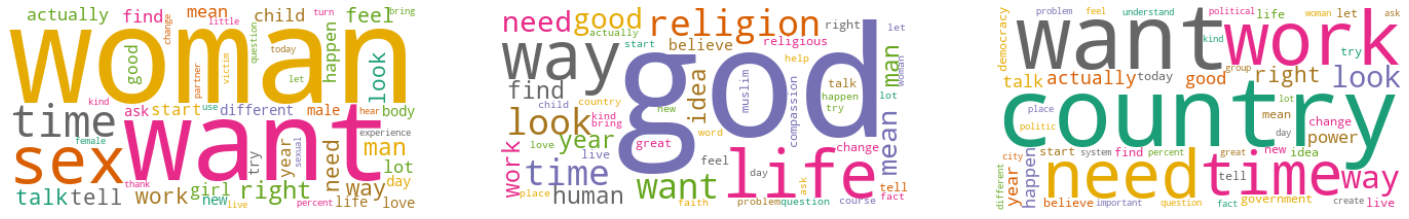

In [119]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

tags = ['sex', 'religion', 'politics']

# Create subplots for each tag
for index, tag in enumerate(all_srp__all_text_dtm_transposed.columns):
    word_cloud.generate(all_srp__text_df.transcript[tag])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(tags[index])
    
plt.show()

## Word Cloud – Nouns and Adjectives

### Update stop words

In [120]:
# Load pickled document-term matrix
all_srp__nouns_adj_dtm = pd.read_pickle('data/all_srp__nouns_adj_dtm.pkl')

# Transpose document-term matrix
all_srp__nouns_adj_dtm_transposed = all_srp__nouns_adj_dtm.transpose()

In [121]:
# Find the top words said by each tag
n_words = 10
top_dict = {}
for tag in all_srp__nouns_adj_dtm_transposed.columns:
    top = all_srp__nouns_adj_dtm_transposed[tag].sort_values(ascending=False).head(n_words)
    top_dict[tag]= list(zip(top.index, top.values))
    
# Print the top words said by each tag
for tag, top_words in top_dict.items():
    print(tag)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
woman, sex, people, man, thing, time, sexual, way, year, girl
---
religion
people, world, thing, way, time, life, religion, year, good, human
---
politics
people, world, year, thing, country, way, time, power, good, political
---


In [122]:
# Look at the most common top words --> add them to the stop word list

# Let's first pull out the top words for each tag
words = []
for tag in all_srp__nouns_adj_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[tag]]
    for t in top:
        words.append(t)

In [123]:
# Let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('people', 3), ('thing', 3), ('time', 3), ('way', 3), ('year', 3), ('world', 2), ('good', 2), ('woman', 1), ('sex', 1), ('man', 1), ('sexual', 1), ('girl', 1), ('life', 1), ('religion', 1), ('human', 1), ('country', 1), ('power', 1), ('political', 1)]


In [124]:
# If all three tags have the top word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
add_stop_words

['people', 'thing', 'time', 'way', 'year']

In [125]:
# Add custom stop words
custom_stop_words = [
#     'sex',
    'world',
#     'religion',
#     'god',
#     'religious',
#     'political',
#     'not',
#     'know',
#     'thing',
#     'know',
#     'think',
#     'come',
#     'people'
]

In [126]:
# Load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [127]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [128]:
# Add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

In [135]:
# Let's update our document-term matrix with the new list of stop words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# Load dataframe
all_srp__nouns_adj_df = pd.read_pickle('data/all_srp__nouns_adj_df.pkl')

# Count vectorize the dataframe
data_cv = cv.fit_transform(all_srp__nouns_adj_df['transcript'])

# Construct new dataframe
all_srp__nouns_adj_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp__nouns_adj_dtm_stop.index = all_srp__nouns_adj_df.index

# Pickle it for later use
with open('data/all_srp__nouns_adj_cv_stop.pkl', 'wb') as f:
    pickle.dump(cv, f)
    f.close()

all_srp__nouns_adj_dtm_stop.to_pickle('data/all_srp__nouns_adj_dtm_stop.pkl')

/Users/miguel/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

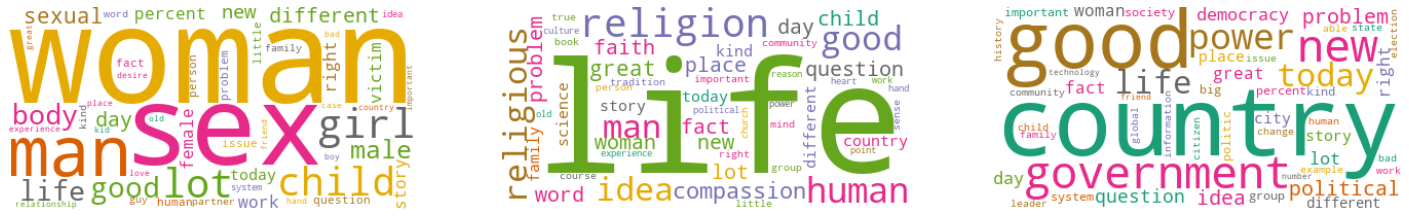

In [136]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

tags = ['sex', 'religion', 'politics']

# Create subplots for each tag
for index, tag in enumerate(all_srp__nouns_adj_dtm_transposed.columns):
    word_cloud.generate(all_srp__nouns_adj_df.transcript[tag])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(tags[index])
    
plt.show()

## Word Cloud – Named Entities

### Update stop words

In [137]:
# Load document-term matrix
all_srp__named_entities_dtm = pd.read_pickle('data/all_srp__named_entities_dtm.pkl')

# Transpose document-term matrix
all_srp__named_entities_dtm_transposed = all_srp__named_entities_dtm.transpose()

In [138]:
# Find the top words said by each tag
n_words = 10
top_dict = {}
for tag in all_srp__named_entities_dtm_transposed.columns:
    top = all_srp__named_entities_dtm_transposed[tag].sort_values(ascending=False).head(n_words)
    top_dict[tag]= list(zip(top.index, top.values))
    
# Print the top words said by each tag
for tag, top_words in top_dict.items():
    print(tag)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
ill, arab, lets, john, mary, darwin, tom, african, ayda, american
---
religion
muslim, muslims, islamic, american, jesus, christian, bin, jewish, darwin, christians
---
politics
american, chinese, americans, lets, african, ill, trump, european, ted, muslims
---


In [139]:
# Look at the most common top words --> add them to the stop word list

# Let's first pull out the top words for each tag
words = []
for tag in all_srp__named_entities_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[tag]]
    for t in top:
        words.append(t)

In [140]:
# Let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('american', 3), ('ill', 2), ('lets', 2), ('darwin', 2), ('african', 2), ('muslims', 2), ('arab', 1), ('john', 1), ('mary', 1), ('tom', 1), ('ayda', 1), ('muslim', 1), ('islamic', 1), ('jesus', 1), ('christian', 1), ('bin', 1), ('jewish', 1), ('christians', 1), ('chinese', 1), ('americans', 1), ('trump', 1), ('european', 1), ('ted', 1)]


In [141]:
# If all three tags have the top word, exclude it
# add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
# add_stop_words

In [148]:
# Add custom stop words
custom_stop_words = [
    'Ill',
    'Lets',
#     'American'
]

In [149]:
# Load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [150]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [155]:
# Add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

In [156]:
# Let's update our document-term matrix with the new list of stop words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# Load dataframe
all_srp__named_entities_df = pd.read_pickle('data/all_srp__named_entities_df.pkl')

# Count vectorize the dataframe
data_cv = cv.fit_transform(all_srp__named_entities_df['transcript'])

# Construct new dataframe
all_srp__named_entities_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp__named_entities_dtm_stop.index = all_srp__named_entities_df.index

# Pickle it for later use
with open('data/all_srp__named_entities_cv_stop.pkl', 'wb') as f:
    pickle.dump(cv, f)
    f.close()

all_srp__named_entities_dtm_stop.to_pickle('data/all_srp__named_entities_dtm_stop.pkl')

/Users/miguel/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ill', 'lets', 'll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

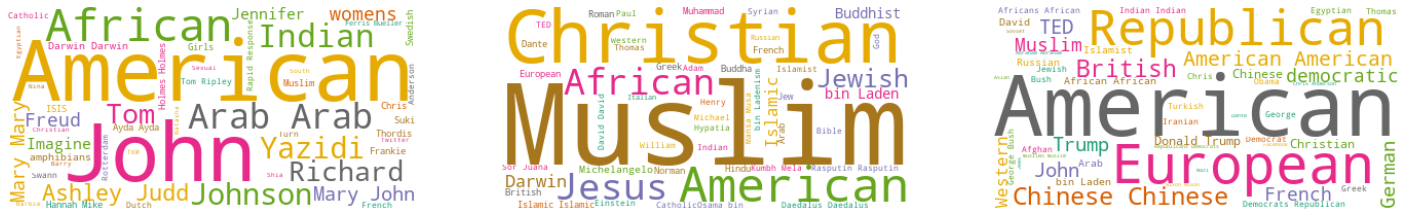

In [157]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

tags = ['sex', 'religion', 'politics']

# Create subplots for each tag
for index, tag in enumerate(all_srp__named_entities_dtm_transposed.columns):
    word_cloud.generate(all_srp__named_entities_df.transcript[tag])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(tags[index])
    
plt.show()

## Word Cloud – Verbs

### Update stop words

In [158]:
# Load document-term matrix
all_srp__verbs_dtm = pd.read_pickle('data/all_srp__verbs_dtm.pkl')

# Transpose document-term matrix
all_srp__verbs_dtm_transposed = all_srp__verbs_dtm.transpose()

In [159]:
# Find the top words said by each tag
n_words = 20
top_dict = {}
for tag in all_srp__verbs_dtm_transposed.columns:
    top = all_srp__verbs_dtm_transposed[tag].sort_values(ascending=False).head(n_words)
    top_dict[tag]= list(zip(top.index, top.values))
    
# Print the top words said by each tag
for tag, top_words in top_dict.items():
    print(tag)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

sex
know, think, want, tell, come, look, talk, feel, need, use, find, happen, ask, mean, work, start, try, hear, turn, thank
---
religion
think, know, come, look, want, believe, tell, find, feel, mean, need, ask, live, use, talk, try, happen, bring, change, start
---
politics
think, know, want, come, need, look, work, happen, tell, use, talk, start, mean, find, try, live, believe, change, ask, create
---


In [160]:
# Look at the most common top words --> add them to the stop word list

# Let's first pull out the top words for each tag
words = []
for tag in all_srp__verbs_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[tag]]
    for t in top:
        words.append(t)

In [161]:
# Let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('know', 3), ('think', 3), ('want', 3), ('tell', 3), ('come', 3), ('look', 3), ('talk', 3), ('need', 3), ('use', 3), ('find', 3), ('happen', 3), ('ask', 3), ('mean', 3), ('start', 3), ('try', 3), ('feel', 2), ('work', 2), ('believe', 2), ('live', 2), ('change', 2), ('hear', 1), ('turn', 1), ('thank', 1), ('bring', 1), ('create', 1)]


In [162]:
# # If all three tags have the top word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 3]
print(add_stop_words)

['know', 'think', 'want', 'tell', 'come', 'look', 'talk', 'need', 'use', 'find', 'happen', 'ask', 'mean', 'start', 'try']


In [163]:
# Add custom stop words
custom_stop_words = [
    'tell',
    'think',
    'know',
    'come',
    'look',
    'need'
]

In [164]:
# Load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [165]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [166]:
# Add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

### Update document-term matrix

In [169]:
# Let's update our document-term matrix with the new list of stop words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# Load the dataframe
all_srp__verbs_df = pd.read_pickle('data/all_srp__verbs_df.pkl')

# Count vectorize the dataframe
data_cv = cv.fit_transform(all_srp__verbs_df['transcript'])

# Construct new dataframe
all_srp__verbs_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
all_srp__verbs_dtm_stop.index = all_srp__verbs_df.index

# Pickle it for later use
with open('data/all_srp__verbs_dtm_stop.pkl', 'wb') as f:
    pickle.dump(cv, f)
    f.close()

all_srp__verbs_dtm_stop.to_pickle('data/all_srp__verbs_dtm_stop.pkl')

/Users/miguel/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


### Word clouds

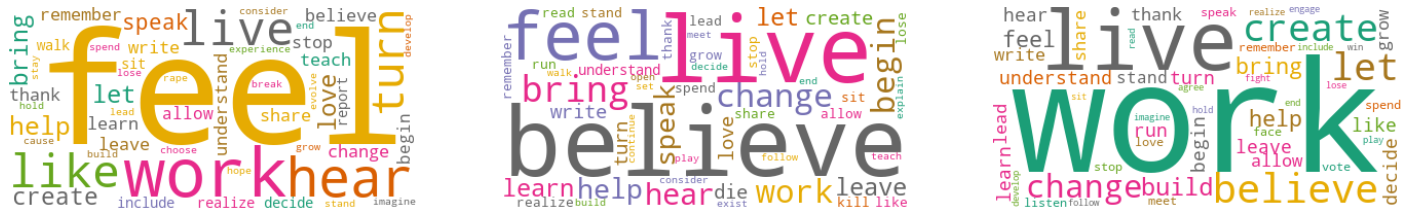

In [170]:
word_cloud = WordCloud(stopwords=stop_words_curated, background_color='white', colormap='Dark2',
                       max_font_size=150, random_state=2020, max_words=50)

plt.rcParams['figure.figsize'] = [25, 10]

tags = ['sex', 'religion', 'politics']

# Create subplots for each tag
for index, tag in enumerate(all_srp__verbs_dtm_transposed.columns):
    word_cloud.generate(all_srp__verbs_df.transcript[tag])
    
    plt.subplot(1, 3, index+1)
    plt.imshow(word_cloud, interpolation="bilinear")
    plt.axis("off")
#     plt.title(tags[index])
    
plt.show()

# Topic Modeling
**Sex - Nouns and Adjectives**

### Stop words

In [175]:
# Load pickled document-term matrix
sex_nouns_adj_dtm = pd.read_pickle('data/sex_nouns_adj_dtm.pkl')

# Transpose document-term matrix
sex_nouns_adj_dtm_transposed = sex_nouns_adj_dtm.transpose()

In [176]:
# Find the top words said in each talk
n_words = 10
top_dict = {}
for title in sex_nouns_adj_dtm_transposed.columns:
    top = sex_nouns_adj_dtm_transposed[title].sort_values(ascending=False).head(n_words)
    top_dict[title]= list(zip(top.index, top.values))
    
# Print the top words in each talk
for title, top_words in top_dict.items():
    print(title)
    print(', '.join([word for word, count in top_words[0:n_words]]))
    print('---')

Why can't we talk about periods?
period, lining, blood, uterus, pain, woman, menstruation, thick, pressure, menstrual
---
The profound power of an authentic apology
father, man, apology, victim, step, year, punishment, thing, violence, abuse
---
Hope and justice for women who've survived ISIS
girl, victim, survivor, woman, community, justice, family, group, sexual, pain
---
How we can eliminate child sexual abuse material from the internet
abuse, child, company, sexual, year, content, material, world, new, image
---
How couples can sustain a strong sexual connection for a lifetime
sex, party, couple, friend, sexual, connection, strong, relationship, desire, way
---
How porn changes the way teens think about sex
pornography, sex, violence, people, sexual, adolescent, study, conversation, year, teenager
---
What is HPV and how can you protect yourself from it?
cell, cancer, strain, treatment, cervix, woman, virus, vaccine, infection, risk
---
How hip-hop helps us understand science
scien

In [177]:
# Look at the most common top words --> add them to the stop word list

# Let's first pull out the top words for each title
words = []
for title in sex_nouns_adj_dtm_transposed.columns:
    top = [word for (word, count) in top_dict[title]]
    for t in top:
        words.append(t)

In [178]:
# Let's aggregate this list and identify the most common words
print(Counter(words).most_common())

[('woman', 28), ('people', 27), ('sex', 24), ('man', 20), ('sexual', 20), ('thing', 18), ('year', 15), ('time', 15), ('girl', 14), ('way', 14), ('female', 9), ('male', 8), ('violence', 7), ('victim', 6), ('child', 6), ('world', 6), ('body', 6), ('human', 6), ('baby', 5), ('partner', 5), ('sexuality', 5), ('question', 5), ('lot', 5), ('different', 5), ('sperm', 5), ('good', 5), ('animal', 5), ('new', 4), ('friend', 4), ('system', 4), ('story', 4), ('day', 4), ('little', 4), ('life', 4), ('love', 4), ('abuse', 3), ('survivor', 3), ('desire', 3), ('study', 3), ('specie', 3), ('work', 3), ('brain', 3), ('young', 3), ('rape', 3), ('state', 3), ('old', 3), ('percent', 3), ('pleasure', 3), ('penis', 3), ('egg', 3), ('medium', 3), ('need', 3), ('insect', 3), ('marriage', 3), ('boy', 3), ('pain', 2), ('community', 2), ('family', 2), ('company', 2), ('image', 2), ('couple', 2), ('relationship', 2), ('conversation', 2), ('cancer', 2), ('treatment', 2), ('bird', 2), ('culture', 2), ('issue', 2), (

In [179]:
# # If more than n talks have the word, exclude it
add_stop_words = [word for word, count in Counter(words).most_common() if count >= 20]
add_stop_words = []
add_stop_words

[]

In [180]:
# Add custom stop words
custom_stop_words = [
    'thing',
    'way',
    'people',
    'sexual'
    'way',
    
]

In [182]:
# Load initial stop words
with open('data/stop_words_spacy.pkl', 'rb') as f:
    initial_stop_words = list(pickle.load(f))
    f.close()

In [183]:
def update_stop_words(list_to_update, add_stop_words, custom_stop_words):
    """Add custom stop words to stop word list"""
    stop_words = list_to_update
    for word in add_stop_words:
        stop_words.append(word)
    for word in custom_stop_words:
        stop_words.append(word)
    return stop_words

In [184]:
# Add new stop words
stop_words_curated = update_stop_words(initial_stop_words, add_stop_words, custom_stop_words)

## Latent Dirichlet Allocation
Latent means hidden, Dirichlet is a type of probability distribution. Latent Dirichlet Allocation means that we are trying to find all the probability distributions and they are hidden.

In [185]:
# Let's update our document-term matrix with the new list of stop words

# Recreate document-term matrix
cv = CountVectorizer(stop_words=stop_words_curated)

# Load dataframe
sex_nouns_adj_df = pd.read_pickle('data/sex_nouns_adj_df.pkl')

# Count vectorize the dataframe
data_cv = cv.fit_transform(sex_nouns_adj_df['transcript'])

# Construct new dataframe
sex_nouns_adj_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
sex_nouns_adj_dtm_stop.index = sex_nouns_adj_df.index

/Users/miguel/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [223]:
# Load document-term matrix
sex_nouns_adj_dtm_stop = pd.read_pickle('data/sex_nouns_adj_dtm_stop.pkl')

# One of the required inputs is a term-document matrix
sex_tdm = sex_nouns_adj_dtm_stop.transpose()
sex_tdm.head()

,Why can't we talk about periods?,The profound power of an authentic apology,Hope and justice for women who've survived ISIS,How we can eliminate child sexual abuse material from the internet,How couples can sustain a strong sexual connection for a lifetime,How porn changes the way teens think about sex,What is HPV and how can you protect yourself from it?,How hip-hop helps us understand science,The uncomplicated truth about women's sexuality,How peer educators can transform sex education,...,Let's talk parenting taboos,"It's time for ""The Talk""",Every pollen grain has a story,"Sex, drugs and HIV -- let's get rational",The fight against sex slavery,10 things you didn't know about orgasm,"Cute, sexy, sweet, funny",Do the green thing,The camel's hump,Designing objects that tell stories
abbreviation,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
abduction,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abhorrent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ability,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
able,0,1,1,1,0,1,1,1,0,1,...,4,0,2,1,0,0,1,0,1,2


In [224]:
# Transform the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
sparse_counts = scipy.sparse.csr_matrix(sex_tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

In [227]:
# Gensim also requires dictionary of the all terms and their respective location in the term-document matrix
cv = pickle.load(open("data/sex_nouns_adj_cv_stop.pkl", "rb"))
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

In [121]:
# LDA for num_topics = 10
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=80)
lda.print_topics()

[(0,
  '0.019*"affair" + 0.011*"door" + 0.008*"sexual" + 0.008*"true" + 0.007*"relationship" + 0.007*"infidelity" + 0.007*"partner" + 0.006*"key" + 0.006*"good" + 0.006*"sex"'),
 (1,
  '0.029*"woman" + 0.015*"sex" + 0.015*"child" + 0.013*"kid" + 0.012*"girl" + 0.011*"family" + 0.011*"life" + 0.011*"year" + 0.009*"young" + 0.009*"parent"'),
 (2,
  '0.019*"sex" + 0.019*"pornography" + 0.015*"sexual" + 0.012*"man" + 0.011*"woman" + 0.011*"body" + 0.010*"relationship" + 0.009*"human" + 0.008*"lot" + 0.008*"year"'),
 (3,
  '0.021*"woman" + 0.012*"sex" + 0.008*"story" + 0.008*"hyman" + 0.007*"girl" + 0.007*"myth" + 0.007*"hymen" + 0.007*"room" + 0.007*"locker" + 0.007*"question"'),
 (4,
  '0.012*"clitoris" + 0.011*"child" + 0.011*"desire" + 0.011*"body" + 0.010*"time" + 0.009*"world" + 0.009*"clit" + 0.008*"abuse" + 0.008*"erotic" + 0.008*"sex"'),
 (5,
  '0.027*"sex" + 0.021*"kit" + 0.017*"rape" + 0.014*"work" + 0.013*"worker" + 0.011*"time" + 0.010*"skeleton" + 0.009*"year" + 0.007*"tissue"

### Findings

* Topic 0: Infidelity
* Topic 1: Family
* Topic 2: Pornography
* Topic 3: Women sex stories (periods, hyman, myths)
* Topic 4: Clitoris
* Topic 5: Rape kit
* Topic 6: ???
* Topic 7: Sex (Women and Men)
* Topic 8: Orgasm
* Topic 9: Sex in animal, plant kingdom

## Non-Negative Matrix Factorization

Find two non-negative matrices (W, H) whose product approximates the non-
negative matrix X. This factorization can be used for example for
dimensionality reduction, source separation or topic extraction.


In [ ]:
# Count vectorize the dataframe
data_cv = cv.fit_transform(sex_nouns_adj_df['transcript'])

# Construct new dataframe
sex_nouns_adj_dtm_stop = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
sex_nouns_adj_dtm_stop.index = sex_nouns_adj_df.index

In [200]:
no_topics = 10

nmf_model = NMF(n_components=no_topics)
doc_topic = nmf_model.fit_transform(data_cv)

In [204]:
component_ix = []
for i in range(1, no_topics+1):
    component_ix.append('component_' + str(i))

In [240]:
# Create df for topics
no_top_words = 10
topic_df = pd.DataFrame()
for ix, topic in enumerate(nmf_model.components_):
    col = 'topic_' + str(ix)
    topic_df[col] = pd.Series(cv.get_feature_names()[i] for i in topic.argsort()[:-no_top_words - 1:-1])

topic_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,woman,sex,child,male,kit,man,desire,gay,pornography,pollen
1,girl,worker,family,female,rape,woman,sexual,agenda,violence,plant
2,sexual,work,year,body,year,issue,partner,lifestyle,sex,insect
3,sex,law,life,penis,time,violence,affair,love,sexual,flower
4,young,money,world,animal,victim,lot,question,time,kid,different
5,man,street,percent,clitoris,state,sexual,good,right,year,little
6,body,industry,time,sperm,police,victim,sex,life,adolescent,lot
7,right,criminalization,today,sex,crime,gender,couple,state,conversation,specie
8,country,client,birth,human,old,culture,time,evil,study,picture
9,time,prostitution,woman,time,work,boy,relationship,lot,problem,nectar


### Findings

* Topic 0: Sex, young women
* Topic 1: Sex workers, legal issues
* Topic 2: Family
* Topic 3: Sexual body parts (penis, clitoris)
* Topic 4: Rape kit
* Topic 5: Violence
* Topic 6: Pleasure
* Topic 7: Gay agenda/lifestyle
* Topic 8: Pornography
* Topic 9: Insect/plant reproduction

# Future Work

## Clustering

## Tag Predictor

## Summarizer

# Appendix

## spaCy attributes

* Text: The original word text.
* Lemma: The base form of the word.
* POS: The simple part-of-speech tag.
* Tag: The detailed part-of-speech tag.
* Dep: Syntactic dependency, i.e. the relation between tokens.
* Shape: The word shape – capitalization, punctuation, digits.
* is alpha: Is the token an alpha character?
* is stop: Is the token part of a stop list, i.e. the most common words of the language?

In [ ]:
# Print token attributes
for doc in docs:
    print('{:<25}{:<25}{:<10}{:<10}{:<15}{:<10}{:<10}{:<10}'.format(
    'Text', 'Lemma', 'POS', 'Tag', 'Dependency', 'Shape', 'Alpha', 'Stop'))
    for token in doc:
        # This is for formatting only
        print('{:<25}{:<25}{:<10}{:<10}{:<15}{:<10}{:<10}{:<10}'.format(
            token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop))
    print('\n')

In [ ]:
# Iterate through each doc in the corpus
for ix, doc in enumerate(docs):
    # Print each doc (transcript)
    print(f'\nDoc: {ix}\n{doc}\n')
    
    # Iterate through the predicted entities
    # Print the entity text and its label
    print(
        tabulate([(ent.text, ent.label_) for ent in doc.ents],
                 headers=['Entity', 'Label'],
                 tablefmt='github'))
    
    # Extract labels from entities and store
    labels = [ent.label_ for ent in doc.ents]
    
    # Iterate through the predicted labels
    # Print the label and its count
    print('\n')
    print(
        tabulate([(count, label) for label, count in Counter(labels).items()],
                 headers=['Count', 'Label'],
                 tablefmt='github'))

## Stanford NLP + SpaCy

In [ ]:
import stanfordnlp
from spacy_stanfordnlp import StanfordNLPLanguage

snlp = stanfordnlp.Pipeline(lang="en")
nlp = StanfordNLPLanguage(snlp)

doc = nlp("Barack Obama was born in Hawaii. He was elected president in 2008.")

In [ ]:
print('{:<25}{:<25}{:<10}{:<10}{:<15}{:<10}{:<10}{:<10}'.format(
'Text', 'Lemma', 'POS', 'Tag', 'Dependency', 'Shape', 'Alpha', 'Stop'), '\n')

for token in doc:
    # This is for formatting only
    print('{:<25}{:<25}{:<10}{:<10}{:<15}{:<10}{:<10}{:<10}'.format(
        token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
        token.shape_, token.is_alpha, token.is_stop))
print('\n')

In [ ]:
from spacy import displacy
displacy.render(doc)